In [2]:
tissue = "ms"
processpath="/cbscratch/franco/trans-eqtl/new_preprocess/gtex/expression/"
normexprpath=processpath+"normalized/ms_normalized.txt"
donorspath ="/cbscratch/franco/datasets/gtex/gtex.sample"
covfile = "/cbscratch/franco/trans-eqtl/preprocess/gtex/expression/covariates/{:s}_nopeer_covariates_w_age.txt".format(tissue)

In [3]:
### Apply LM correction (python)
from sklearn import linear_model
import pandas as pd
import numpy as np

# Original lmcorrect method (same as R implementation)
def lmcorrect(expression_df, cov_df):   
    donor_ids = expression_df.columns

    #sort donors
    cov_df = cov_df[expression_df.columns]

    reg = linear_model.LinearRegression()
    reg.fit(cov_df.T, expression_df.T)

    # reg.score(df_cov.T, crop_expression_df.T)
    # print(reg.coef_)
    residuals = expression_df - reg.predict(cov_df.T).T
    return residuals, reg.coef_

# Fits lasso linear model all at one, in the numpy docs you can see that the multi target optimization
# is different and this makes 1 singular value == 0
def lmcorrect_lasso(expression_df, df_cov, alpha=0.05):     
    #sort donors
    sort_df_cov = df_cov[expression_df.columns]
    
    reg = linear_model.Lasso(alpha = alpha)
    reg.fit(sort_df_cov.T, expression_df.T)

    # print(reg.score(sort_df_cov.T, expression_df.T))
    residuals = expression_df - reg.predict(sort_df_cov.T).T
    return residuals, reg.coef_

# iterates over each Gene and fits Lasso linear model
def correct_lasso_iterative(expression_df, df_cov, alpha=0.05):   
    #sort donors
    sort_df_cov = df_cov[expression_df.columns]
    
    residuals = np.zeros(expression_df.shape)
    coefs = np.zeros((expression_df.shape[0], sort_df_cov.shape[0]))
    for i in range(expression_df.shape[0]):
        reg = linear_model.Lasso(alpha = alpha)
        reg.fit(sort_df_cov.T, expression_df.iloc[i])

        # print(i, reg.score(sort_df_cov.T, expression_df.iloc[i].T), reg.coef_)
        residuals[i] = expression_df.iloc[i] - reg.predict(sort_df_cov.T).T
        coefs[i,:] = reg.coef_
    df_residuals = pd.DataFrame(residuals, columns=expression_df.columns, index=expression_df.index)
    return df_residuals, coefs

# Original lmcorrect method (same as R implementation)
def correct_linear_iterative(expression_df, df_cov):   
    #sort donors
    sort_df_cov = df_cov[expression_df.columns]

    residuals = np.zeros(expression_df.shape)
    coefs = np.zeros((expression_df.shape[0], sort_df_cov.shape[0]))
    for i in range(expression_df.shape[0]):
        reg = linear_model.LinearRegression()
        reg.fit(sort_df_cov.T, expression_df.iloc[i])

        residuals[i] = expression_df.iloc[i] - reg.predict(sort_df_cov.T).T
        coefs[i,:] = reg.coef_
    df_residuals = pd.DataFrame(residuals, columns=expression_df.columns, index=expression_df.index)
    return df_residuals, coefs

# Fits linear regression only on those covariates that (from a previous iteration) have beta != 0
def lmcorrect_select(expression_df, df_cov, prev_coefs):   
    #sort donors
    sort_df_cov = df_cov[expression_df.columns]
    residuals = np.zeros(expression_df.shape)
    coefs = np.zeros(prev_coefs.shape)
    for i in range(prev_coefs.shape[0]):
        ix = np.abs(prev_coefs[i,:]) > 0
        if np.sum(ix) == 0:
            residuals[i] = expression_df.iloc[i]
        else:
            slice_covs = sort_df_cov[ix]
            # print(slice_covs.index)
            reg = linear_model.LinearRegression()
            reg.fit(slice_covs.T, expression_df.iloc[i])

            # reg.score(df_cov.T, crop_expression_df.T)
            # print(reg.coef_)
            residuals[i] = expression_df.iloc[i] - reg.predict(slice_covs.T).T
            coefs[i,:len(reg.coef_)] = reg.coef_
    df_residuals = pd.DataFrame(residuals, columns=expression_df.columns, index=expression_df.index)
    return df_residuals, coefs

def _normalize_expr(Y):
    newY = (Y - np.mean(Y, axis = 1).reshape(-1, 1)) / np.std(Y, axis = 1).reshape(-1, 1)
    return newY

def gene_distance(a, b):
    return np.linalg.norm(a - b)

from sklearn.decomposition import PCA

def knn_correction(expr):
    pca = PCA(n_components=min(expr.shape[0], expr.shape[1]))
    print("Original dimension: {:d} x {:d}".format(expr.shape[0], expr.shape[1]))
    pca.fit(expr) # requires N x G
    expr_pca = pca.transform(expr)
    print("Reduced dimension: {:d} x {:d}".format(expr_pca.shape[0], expr_pca.shape[1]))

    nsample = expr.shape[0]
    distance_matrix = np.zeros((nsample, nsample))
    for i in range(nsample):
        for j in range(i+1, nsample):
            dist = gene_distance(expr_pca[i,:], expr_pca[j,:])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    kneighbor = 30
    gx_knn = np.zeros_like(expr)

    for i in range(nsample):
        neighbors = np.argsort(distance_matrix[i, :])[:kneighbor + 1][1:]
        gx_knn[i, :] = expr[i, :] - np.mean(expr[neighbors, :], axis = 0)

    return gx_knn.T #, gt_knn

In [4]:

# load expr
df_expr = pd.read_table(normexprpath, header=0, index_col=0)

# load covariates
covfile = processpath+"covariates/{:s}_nopeer_covariates_w_age.txt".format(tissue)
df_cov = pd.read_table(covfile, header=0, index_col=0)

# QC filtering
expr_corr, coefs = lmcorrect(df_expr, df_cov)

print(np.linalg.matrix_rank(df_expr.values))
print(np.linalg.matrix_rank(expr_corr.values))
print(df_expr.values.shape, df_cov.shape)

361
353
(23043, 361) (8, 361)


In [5]:
df_cov.head()

,GTEX-1117F,GTEX-111CU,GTEX-111FC,GTEX-111VG,GTEX-111YS,GTEX-1122O,GTEX-1128S,GTEX-113JC,GTEX-117XS,GTEX-117YW,...,GTEX-ZY6K,GTEX-ZYFC,GTEX-ZYFD,GTEX-ZYFG,GTEX-ZYT6,GTEX-ZYWO,GTEX-ZYY3,GTEX-ZZ64,GTEX-ZZPT,GTEX-ZZPU
ID,,,,,,,,,,,,,,,,,,,,,
C1,0.1080,-0.018,-0.0156,-0.0197,-0.0215,-0.0205,-0.0202,-0.0152,-0.0206,-0.0166,...,0.1206,0.1142,-0.0212,-0.0202,-0.0203,-0.0209,-0.0167,-0.0219,-0.0228,-0.0210
C2,0.0121,0.001,0.0168,0.0108,0.0130,0.0164,0.0106,-0.0058,0.0011,-0.0019,...,0.0040,0.0148,0.0152,0.0011,0.0130,-0.0021,0.0049,-0.0019,0.0008,0.0051
C3,0.0032,0.006,0.0100,0.0041,0.0081,0.0178,0.0322,-0.0100,-0.0233,-0.1010,...,-0.0026,0.0232,-0.0050,0.0074,0.0116,-0.0231,-0.1054,0.0189,0.0406,-0.0099
gender,1.0000,2.000,2.0000,2.0000,2.0000,1.0000,1.0000,1.0000,2.0000,2.0000,...,2.0000,2.0000,2.0000,1.0000,2.0000,1.0000,1.0000,2.0000,2.0000,1.0000
Platform,1.0000,1.000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,...,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [68]:
# correct with KNN
gx_knn =  knn_correction(df_expr.values.T)
gx_knn = pd.DataFrame(gx_knn, columns = df_expr.columns, index=df_expr.index)

# export KNN expression
gx_knn.index.name = "gene_id"
if not os.path.exists(processpath+"knn"):
     os.makedirs(processpath+"knn")
norm_lasso_it.to_csv(processpath+"knn/ms_knn.txt", header=True, sep="\t")

Original dimension: 361 x 23043
Reduced dimension: 361 x 361
Rank: 360


In [39]:
import os

means = np.mean(df_cov.T)
stds = np.std(df_cov.T)
diff = (df_cov.T - means) / stds
scaled_df_cov = diff.T

# Correct with LASSO iterative
lasso_expr_it, lasso_coefs = correct_lasso_iterative(df_expr, scaled_df_cov)
print(lasso_coefs.shape)
print(np.linalg.matrix_rank(df_expr))
print(np.linalg.matrix_rank(lasso_expr_it))

# Correct with LM iterative
lm_expr_it, lm_coefs = correct_linear_iterative(df_expr, df_cov)
print(np.linalg.matrix_rank(lm_expr_it))


lm_expr_select, lm_coefs_select = lmcorrect_select(df_expr, df_cov, lasso_coefs)
print(np.linalg.matrix_rank(lm_expr_select))

(23043, 8)
(23043, 8)
361
360
(23043, 8)
353
361


In [1]:
df_cov

NameError: name 'df_cov' is not defined

In [27]:
# normalize lasso expression and check rank
norm_lasso_it = _normalize_expr(lasso_expr_it.values)
norm_lasso_it = pd.DataFrame(norm_lasso_it, columns = lasso_expr_it.columns, index=lasso_expr_it.index)
print(np.linalg.matrix_rank(norm_lasso_it))

norm_lm_it = _normalize_expr(lm_expr_it.values)
print(np.linalg.matrix_rank(norm_lm_it))

360
352


In [28]:
# export lasso expression
norm_lasso_it.index.name = "gene_id"
if not os.path.exists(processpath+"lasso"):
     os.makedirs(processpath+"lasso")
norm_lasso_it.to_csv(processpath+"lasso/ms_lasso.txt", header=True, sep="\t")

In [48]:
norm_lm_select = _normalize_expr(lm_expr_select.values)
print(np.linalg.matrix_rank(norm_lm_select))
norm_lm_select = pd.DataFrame(norm_lm_select, columns = lm_expr_select.columns, index=lm_expr_select.index)

# export lm expression
norm_lm_select.index.name = "gene_id"
if not os.path.exists(processpath+"lmcorrected_it"):
     os.makedirs(processpath+"lmcorrected_it")
norm_lm_select.to_csv(processpath+"lmcorrected_it/ms_lmcorrected.txt", header=True, sep="\t")

360


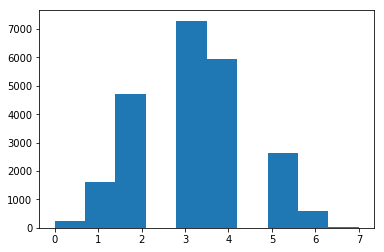

In [38]:
import matplotlib.pyplot as plt
plt.hist(np.sum(lasso_coefs != 0, axis=1))
plt.show()

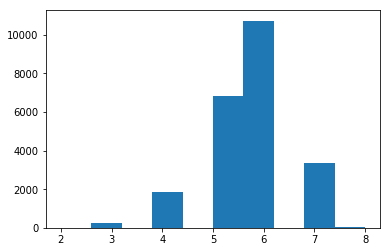

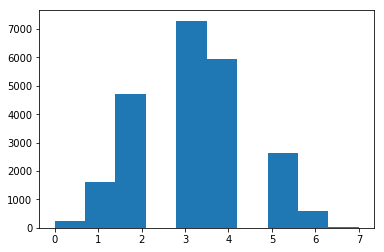

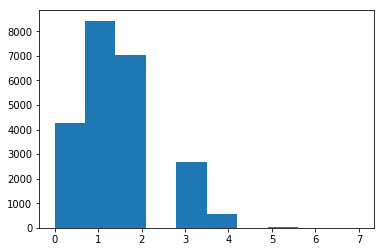

In [71]:
from sklearn import linear_model
import pandas as pd
import numpy as np

tissue = "ms"
processpath="/cbscratch/franco/trans-eqtl/new_preprocess/gtex/expression/"
normexprpath=processpath+"normalized/ms_normalized.txt"
donorspath ="/cbscratch/franco/datasets/gtex/gtex.sample"
covfile = "/cbscratch/franco/trans-eqtl/preprocess/gtex/expression/covariates/{:s}_nopeer_covariates_w_age.txt".format(tissue)

# load expr
df_expr = pd.read_table(normexprpath, header=0, index_col=0)

# load covariates
df_cov = pd.read_table(covfile, header=0, index_col=0)

# scale covariates
means = np.mean(df_cov.T)
stds = np.std(df_cov.T)
diff = (df_cov.T - means) / stds
scaled_df_cov = diff.T

def normalize_expr(Y):
    newY = (Y - np.mean(Y, axis = 1).reshape(-1, 1)) / np.std(Y, axis = 1).reshape(-1, 1)
    return newY

def correct_lasso_iterative(expression_df, df_cov, alpha=0.05):   
    #sort donors
    sort_df_cov = df_cov[expression_df.columns]
    
    residuals = np.zeros(expression_df.shape)
    coefs = np.zeros((expression_df.shape[0], sort_df_cov.shape[0]))
    for i in range(expression_df.shape[0]):
        reg = linear_model.Lasso(alpha = alpha)
        reg.fit(sort_df_cov.T, expression_df.iloc[i])

        # print(i, reg.score(sort_df_cov.T, expression_df.iloc[i].T), reg.coef_)
        residuals[i] = expression_df.iloc[i] - reg.predict(sort_df_cov.T).T
        coefs[i,:] = reg.coef_
    df_residuals = pd.DataFrame(residuals, columns=expression_df.columns, index=expression_df.index)
    return df_residuals, coefs

for alpha in [0.01, 0.05, 0.1]:
    lasso_expr, lasso_coefs = correct_lasso_iterative(df_expr, scaled_df_cov, alpha=alpha)
    plt.hist(np.sum(lasso_coefs != 0, axis=1))
    plt.show()


    # center and scale lasso expression
    norm_lasso_it = normalize_expr(lasso_expr.values)
    norm_lasso_it = pd.DataFrame(norm_lasso_it, columns = df_expr.columns, index=df_expr.index)

    # export lasso expression
    norm_lasso_it.index.name = "gene_id"
    if not os.path.exists("lasso_"+str(alpha)):
         os.makedirs("lasso_"+str(alpha))
    norm_lasso_it.to_csv("lasso_"+str(alpha)+"/ms_lasso.txt", header=True, sep="\t")